In [14]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import japanize_matplotlib
from os.path import join
from settings import geodatadir
import itertools
# 地図は背景に地理院地図（国土地理院）を使用している場合があります。

In [18]:
mesh_codes = list(itertools.chain.from_iterable(
    [(np.array([5238, 5239, 5240]) + xx) for xx in [0, 100, 200, 300]]))

In [20]:
mesh = pd.concat([gpd.read_file(join(geodatadir, f'mesh500/HDDSWH{x}/MESH0{x}.shp'), crs=4612).to_crs(2451) for x in mesh_codes])
mesh = mesh[['KEY_CODE', 'geometry']]
mesh.KEY_CODE = mesh.KEY_CODE.astype(str)

In [21]:
# mesh.to_file('data/syutoken_mesh.geojson', driver='GeoJSON')

In [22]:
kokusei = pd.concat([pd.read_csv(join(geodatadir, f"kokutyou500/tblT000847H{x}.txt"), encoding='sjis', skiprows=[1]) for x in mesh_codes])
kokusei = kokusei[['KEY_CODE', 'T000847001']]
kokusei.columns = ['KEY_CODE', 'people']
kokusei.KEY_CODE = kokusei.KEY_CODE.astype(str)
kokusei = pd.merge(mesh, kokusei, on='KEY_CODE')

In [80]:
keizai = pd.concat([pd.read_csv(join(geodatadir, f"keizai500/tblT000389H{x}.txt"), encoding='sjis', skiprows=1) for x in mesh_codes])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')

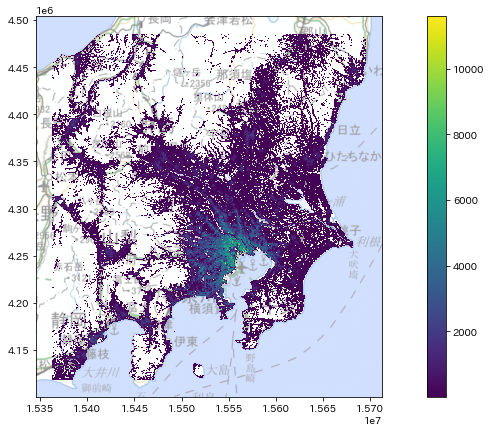

In [23]:
ax = kokusei.to_crs(3857).plot('people', legend=True, figsize=(16, 7))
cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png', alpha=0.7)

In [45]:
x = gpd.read_file(join(geodatadir, 'stations.geojson'), crs=4612).to_crs(2451)
stations = x[x.distance(x[x.N02_005 == '東京'].geometry.values[0]) <= 80 * 1000]

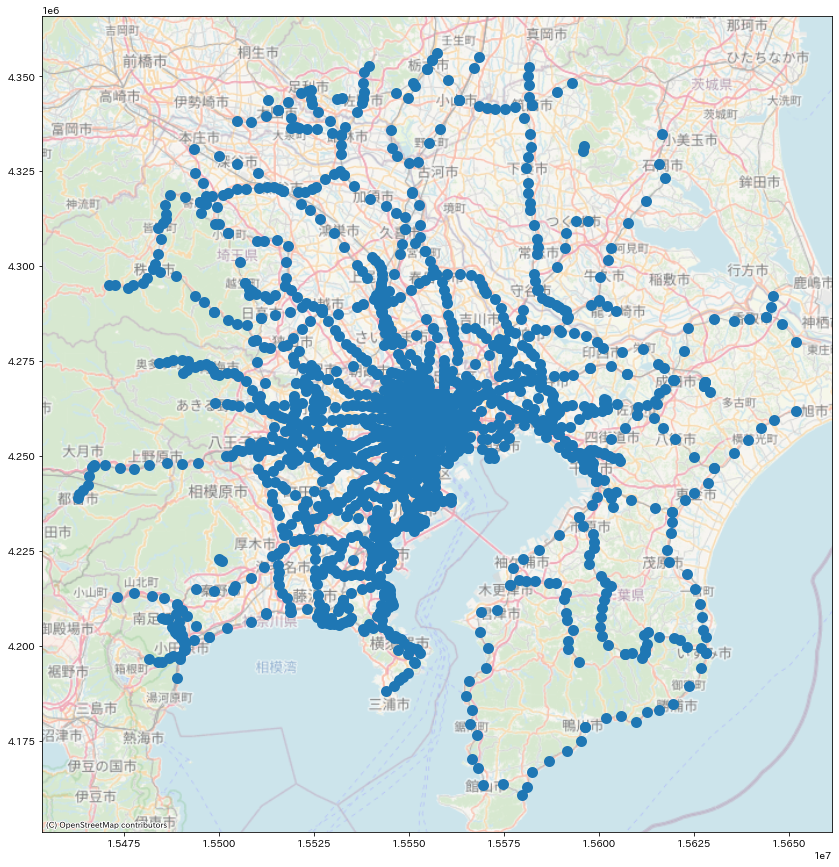

In [50]:
# cx.add_basemap(stations.to_crs(3857).plot(figsize=(10, 10), edgecolors='black', linewidths=5), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.3)
x = stations.to_crs(3857)
x.geometry = x.geometry.centroid
cx.add_basemap(x.plot(figsize=(15, 15), linewidths=5), source=cx.providers.OpenStreetMap.Mapnik, alpha=0.6)

In [57]:
stations_buffer = stations.copy()
stations_buffer.geometry = stations_buffer.geometry.buffer(1500)
stations_buffer['stacode'] = stations_buffer.index
kokusei['area_t'] = kokusei.area
ans = gpd.overlay(kokusei, stations_buffer)
ans['ans'] = ans.people * (ans.area / ans.area_t)
ans = ans.groupby('stacode').sum().reset_index()[['stacode', 'ans']]
ans = pd.merge(stations_buffer, ans, on='stacode').iloc[:, 2:]
ans.sort_values('ans')

,N02_003,N02_004,N02_005,geometry,stacode,ans
773,東京モノレール羽田線,東京モノレール,新整備場,"POLYGON ((-5597.002 -50130.937, -5589.270 -501...",5974,1.000000
770,東京モノレール羽田線,東京モノレール,羽田空港第2ビル,"POLYGON ((-2733.993 -49193.353, -2670.495 -493...",5971,1.000000
767,東京モノレール羽田線,東京モノレール,羽田空港第1ビル,"POLYGON ((-3126.767 -49253.406, -3113.416 -492...",5968,1.000000
279,空港線,京浜急行電鉄,羽田空港国内線ターミナル,"POLYGON ((-5071.657 -48665.828, -5037.387 -486...",881,1.000000
715,筑波山鋼索鉄道線,筑波観光鉄道,筑波山頂,"POLYGON ((23136.544 23889.099, 23023.385 23983...",5160,72.142245
...,...,...,...,...,...,...
1100,10号線新宿線,東京都,西大島,"POLYGON ((-647.313 -35964.678, -680.454 -35965...",6301,183847.892438
1431,赤羽線（埼京線）,東日本旅客鉄道,板橋,"POLYGON ((-11647.529 -27577.498, -11640.443 -2...",7305,184714.515319
274,空港線,京浜急行電鉄,京急蒲田,"POLYGON ((-8534.539 -49291.348, -8545.955 -493...",876,185479.927294
302,本線,京浜急行電鉄,京急蒲田,"POLYGON ((-8534.539 -49291.348, -8545.955 -493...",904,185479.927294


In [66]:
ans.ans = ans.ans.astype(int)
ans.geometry = ans.geometry.centroid
ans = ans.sort_values('ans', ascending=False).reset_index().drop('index', 1)
ans['rank'] = ans.index + 1
ans

,N02_003,N02_004,N02_005,geometry,stacode,ans,rank
0,東上本線,東武鉄道,下板橋,POINT (-10644.704 -28284.257),8373,186224,1
1,空港線,京浜急行電鉄,京急蒲田,POINT (-9882.965 -48620.967),876,185479,2
2,本線,京浜急行電鉄,京急蒲田,POINT (-9882.965 -48620.967),904,185479,3
3,赤羽線（埼京線）,東日本旅客鉄道,板橋,POINT (-10324.966 -28286.201),7305,184714,4
4,10号線新宿線,東京都,西大島,POINT (-634.755 -34466.580),6301,183847,5
...,...,...,...,...,...,...,...
2034,筑波山鋼索鉄道線,筑波観光鉄道,筑波山頂,POINT (24066.096 25066.874),5160,72,2035
2035,空港線,京浜急行電鉄,羽田空港国内線ターミナル,POINT (-4304.172 -49955.213),881,1,2036
2036,東京モノレール羽田線,東京モノレール,羽田空港第2ビル,POINT (-4091.931 -49835.550),5971,1,2037
2037,東京モノレール羽田線,東京モノレール,新整備場,POINT (-4219.124 -50719.190),5974,1,2038


In [68]:
ans.to_file('data/ans-kyojyu.geojson', driver='GeoJSON')

In [69]:
kokusei.to_file('data/kokusei-syutoken-kouiki.geojson', driver='GeoJSON')

In [81]:
ans['tokyo'] = ans.distance(stations[stations.N02_005 == '東京'].geometry.values[0]).astype(int)
d = []
keizai2 = keizai[keizai.people >= 5000]
for row in ans.geometry:
    x = []
    for g, p in zip(keizai2.geometry.centroid, keizai2.people):
        x.append(p / ((row.distance(g) ** 1.5) + 250))
    d.append(sum(x))
ans['koyou'] = d

In [95]:
ans['koyou10'] = np.log10(ans.koyou)
ans['tokyo10'] = np.log10(ans.tokyo)

In [96]:
ans2 = ans.drop('geometry', 1)

array([[<AxesSubplot:title={'center':'ans'}>]], dtype=object)

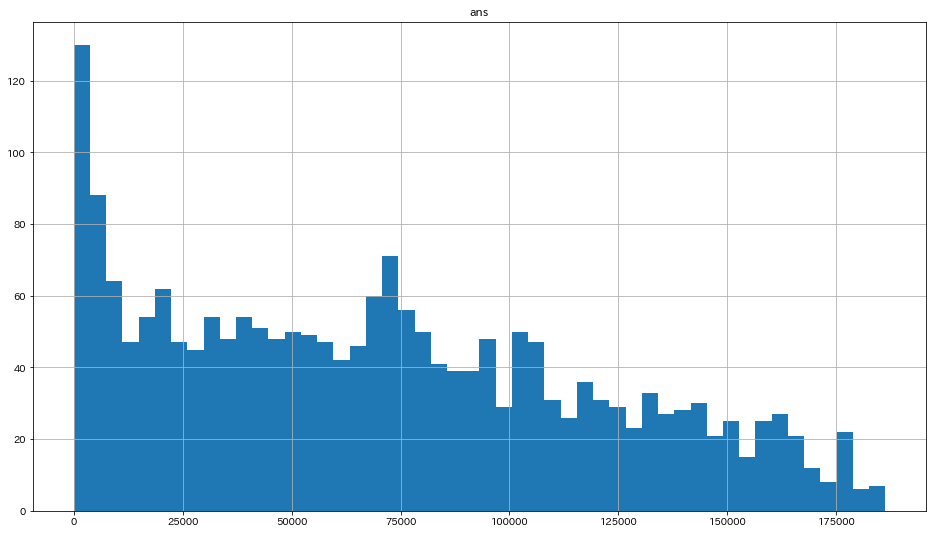

In [102]:
ans2.hist('ans', bins=50, figsize=(16,9))

<AxesSubplot:xlabel='tokyo', ylabel='ans'>

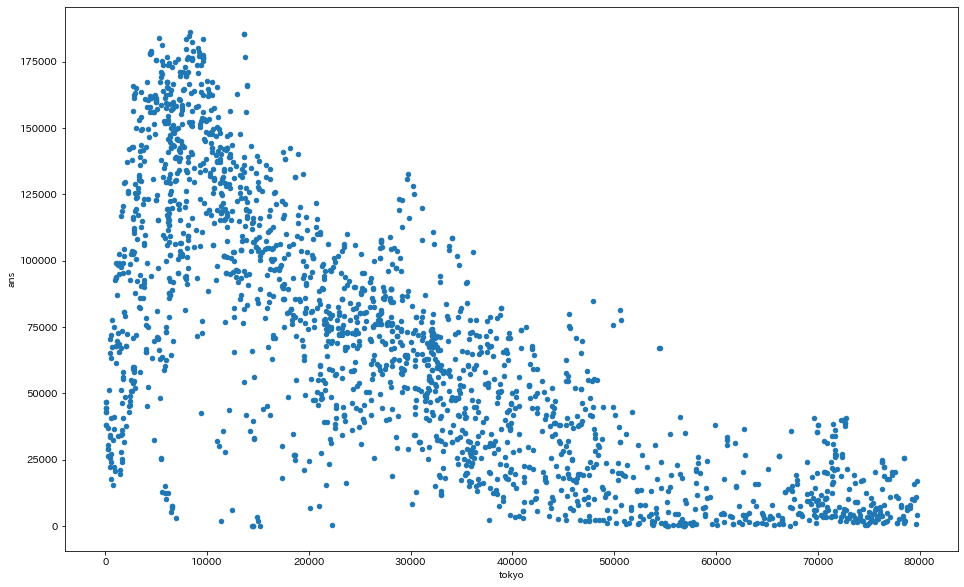

In [105]:
ans2.plot(x='tokyo', y='ans', kind='scatter', figsize=(16, 10))

In [92]:
x = ans2[(ans2.koyou10 < 1.1) & (ans2.koyou10 > 0.9)]
x

,N02_003,N02_004,N02_005,stacode,ans,rank,tokyo,koyou,koyou10
0,東上本線,東武鉄道,下板橋,8373,186224,1,8359,9.024529,0.955425
3,赤羽線（埼京線）,東日本旅客鉄道,板橋,7305,184714,4,8181,8.941441,0.951408
4,10号線新宿線,東京都,西大島,6301,183847,5,5319,9.553013,0.980140
6,東上本線,東武鉄道,北池袋,8365,183369,7,7898,11.096350,1.045180
7,1号線浅草線,東京都,戸越,6257,182250,8,8561,10.478305,1.020291
...,...,...,...,...,...,...,...,...,...
1737,東京臨海新交通臨海線,ゆりかもめ,お台場海浜公園,2,12824,1738,5588,11.454600,1.058980
1743,東京臨海新交通臨海線,ゆりかもめ,青海,13,12430,1744,6181,9.812890,0.991797
1862,東京臨海新交通臨海線,ゆりかもめ,船の科学館,3,5493,1863,6431,9.666496,0.985269
1932,東京臨海新交通臨海線,ゆりかもめ,テレコムセンター,4,2989,1933,6926,8.117197,0.909406


In [ ]:
x = ans2[(ans2.koyou10 < 1.1) & (ans2.koyou10 > 0.9)]
x

,N02_003,N02_004,N02_005,stacode,ans,rank,tokyo,koyou,koyou10
0,東上本線,東武鉄道,下板橋,8373,186224,1,8359,9.024529,0.955425
3,赤羽線（埼京線）,東日本旅客鉄道,板橋,7305,184714,4,8181,8.941441,0.951408
4,10号線新宿線,東京都,西大島,6301,183847,5,5319,9.553013,0.980140
6,東上本線,東武鉄道,北池袋,8365,183369,7,7898,11.096350,1.045180
7,1号線浅草線,東京都,戸越,6257,182250,8,8561,10.478305,1.020291
...,...,...,...,...,...,...,...,...,...
1737,東京臨海新交通臨海線,ゆりかもめ,お台場海浜公園,2,12824,1738,5588,11.454600,1.058980
1743,東京臨海新交通臨海線,ゆりかもめ,青海,13,12430,1744,6181,9.812890,0.991797
1862,東京臨海新交通臨海線,ゆりかもめ,船の科学館,3,5493,1863,6431,9.666496,0.985269
1932,東京臨海新交通臨海線,ゆりかもめ,テレコムセンター,4,2989,1933,6926,8.117197,0.909406


In [103]:
ans2.to_csv('data/ans-kyojyu.csv', index=None)

<AxesSubplot:xlabel='rank'>

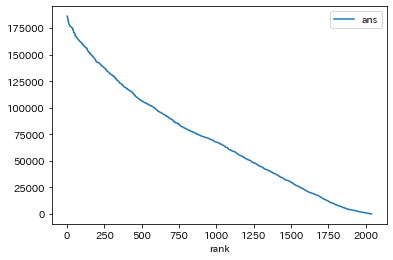

In [104]:
ans2.plot(kind='line', x='rank', y='ans')